In [82]:
import numpy as np
import plotly.graph_objects as go
import open3d as o3d
import cv2
import matplotlib.pyplot as plt

In [83]:
pc_path = '/home/siddhartha/RIVAL/learning2localize/blender/dataset/apple_orchard_pc.npy'
pc_np = np.load(pc_path)

In [84]:
rgb_img = cv2.imread('/home/siddhartha/RIVAL/learning2localize/blender/dataset/apple_orchard_rgb0000.png')
rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
rgb_3d = rgb_img.reshape(-1, 3)

pc_3d = pc_np.reshape(-1, 3)

# drop nans
rgb_3d = rgb_3d[~np.isnan(pc_3d).any(axis=1)]
pc_3d = pc_3d[~np.isnan(pc_3d).any(axis=1)]
pc_3d.shape, rgb_3d.shape

((801854, 3), (801854, 3))

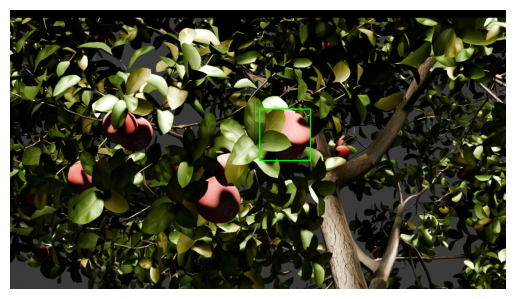

In [85]:
rgb_cp = rgb_img.copy()
x1, y1, x2, y2 = 644.0, 388.0, 775.0, 255.0
cv2.rectangle(rgb_cp, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
plt.imshow(rgb_cp)
plt.axis('off')
plt.show()

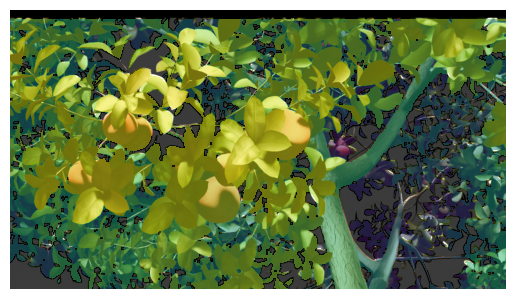

-1.4038584232330322

In [86]:
plt.imshow(rgb_img)
plt.axis('off')
plt.imshow(pc_np[:, :, 2], alpha=0.5)
plt.show()
pc_np[:,:,2][500,500]

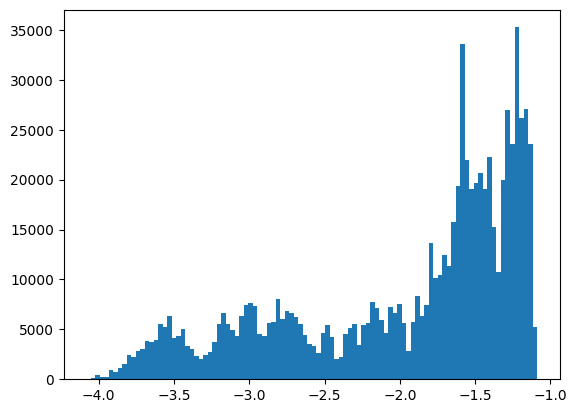

In [87]:
z_vals = pc_3d[:, 2].flatten()
# z_vals = z_vals[z_vals > -10000000000.0]
plt.hist(z_vals, bins=100)
plt.show()


In [88]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pc_3d)
pcd.colors = o3d.utility.Vector3dVector(rgb_3d / 255.0)

# Create and position the sphere
sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.01)
sphere.translate((0.04752582311630249, -0.03126762807369232, -1.212427020072937))
sphere.paint_uniform_color([1, 0, 0])  # Red color

# Visualize both geometries together
o3d.visualization.draw_geometries([pcd, sphere])

Pixel at (500, 500) corresponds to object: apple105


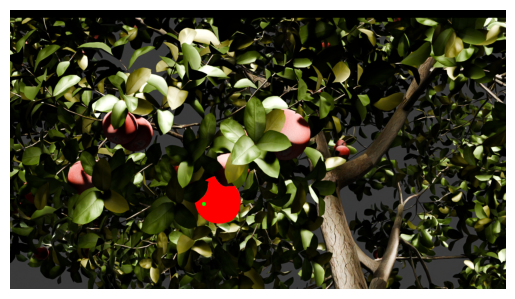

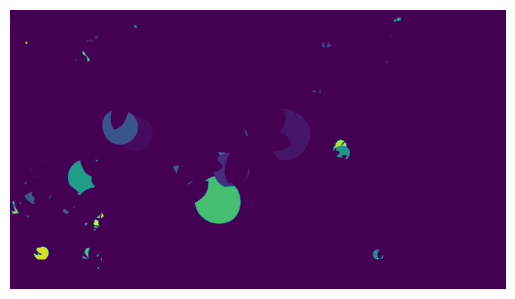

In [89]:

import json
import pyexr

# Load the object ID mask
with pyexr.open("/home/siddhartha/RIVAL/learning2localize/blender/dataset/apple_orchard_id0000.exr") as exr_file:
    # print(exr_file.channel_map)
    object_id_channel = exr_file.get("V")  # Shape: (height, width, 1)
    object_ids = object_id_channel[:, :, 0]  # Convert to 2D array

# Load the mapping from pass indices to object names
with open("/home/siddhartha/RIVAL/learning2localize/blender/dataset/apple_orchard_id_map.json", "r") as f:
    id_to_name = json.load(f)

# Example: Get the object name at pixel (y, x)
y, x = 500, 500
object_id = int(object_ids[y, x])
object_name = id_to_name.get(str(object_id), "Unknown")

print(f"Pixel at ({y}, {x}) corresponds to object: {object_name}")
img_cp = rgb_img.copy()
img_cp[object_ids == object_id] = [255, 0, 0]  # Change color to red for the selected object
# draw circle at y,x
cv2.circle(img_cp, (x, y), 5, (0, 255, 0), -1)  # Draw a green circle at (x, y)
plt.imshow(img_cp)
plt.axis('off')
plt.show()

# build apple instance mask
visible_ids = np.unique(object_ids).astype(int)
visible_ids = visible_ids[visible_ids != 0]
visible_apples = []
for id in visible_ids:
    name = id_to_name.get(str(id), "Unknown")
    if 'apple' in name and 'stem' not in name:
        visible_apples.append((id, name))
img_cp  = rgb_img.copy()
mask = np.zeros(img_cp.shape[:2], dtype=np.uint8)
for i, (id, name) in enumerate(visible_apples):
    mask[object_ids == id] = i+1

plt.imshow(mask)
plt.axis('off')
plt.savefig('/home/siddhartha/Downloads/mask.png', dpi=300, bbox_inches='tight')
plt.show()
# visualize apple instances